In [1]:
import pandas as pd

df = pd.read_csv(
    r"C:\Users\nrebe\Downloads\Spam Filter\preprocessed_sms_spam.csv"
)

df.head()


,label,text,clean_text,final_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think go usf life around though


#  Model Training & Evaluation

In this notebook, we begin the **modeling phase** of the SMS Spam Classification project. 

###  **1. Loading the preprocessed dataset**
We start from a clean, ready-to-model version of the SMS messages stored in the project folder.

###  **2. Splitting the data into train and test sets**
Using a stratified approach to preserve the original label distribution (ham vs spam).

###  **3. Transforming text into numerical features**
We will use **TF-IDF Vectorization**, implemented inside a Scikit-Learn Pipeline to avoid data leakage and ensure reproducibility.

###  **4. Training classification models**
Our primary model will be **Logistic Regression**, as it provides well-calibrated probabilities required to support adjustable spam-risk levels.

We may also test simpler baselines such as **Multinomial Naive Bayes** for comparison.

---


###  **5. Implementing adjustable risk thresholds**
The service team requires two modes:
- **Low-risk mode** (strict spam filtering)
- **High-risk mode** (less restrictive to avoid losing legitimate customers)

In [11]:
from sklearn.model_selection import train_test_split

X = df["final_text"]
Y = df["label"]

X_train,X_test,y_train,y_test= train_test_split (
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
    
)

print("Training samples:", len(X_train))
print("Test samples:", len(X_test))

Training samples: 4135
Test samples: 1034


In [13]:
X_train.isna().sum(), X_test.isna().sum()


(5, 1)

In [14]:
X_train = X_train.fillna("")
X_test = X_test.fillna("")

X_train.isna().sum(), X_test.isna().sum()


(0, 0)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),      
    min_df=3,              
    max_df=0.95,             
    sublinear_tf=True       

# Fit on training data and transform
X_train_tfidf = tfidf.fit_transform(X_train)

# Only transform the test data 
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape


((4135, 2894), (1034, 2894))

###  TF-IDF Matrix Shape (Train & Test)

The output shows the shape of the TF-IDF matrices created for the training and test sets:

- **Training set:** `(4135, 2894)`
- **Test set:** `(1034, 2894)`

This means:

- We have **4,135 training messages** and **1,034 test messages** (after stratified split).
- Each message is now represented as a numeric vector of **2,894 TF-IDF features**.
- The number of features (2894) corresponds to the size of the vocabulary learned from the training set, considering:
  - unigrams and bigrams  
  - min_df=3 (removing very rare words)  
  - max_df=0.95 (removing extremely common words)

These matrices are the input to the machine learning model.  
Each row represents a message, and each column is a weighted TF-IDF token.


---  

# Logistic Regression 

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create Logistic Regression model
log_reg = LogisticRegression(
    solver="liblinear",      
    class_weight="balanced", 
    random_state=42
)

# Train the model
log_reg.fit(X_train_tfidf, y_train)

# Predictions (default threshold 0.5)
y_pred = log_reg.predict(X_test_tfidf)

# Predicted probabilities for spam (needed later for thresholds)
y_proba_spam = log_reg.predict_proba(X_test_tfidf)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9700193423597679

Classification report:

              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       903
        spam       0.86      0.91      0.88       131

    accuracy                           0.97      1034
   macro avg       0.92      0.94      0.93      1034
weighted avg       0.97      0.97      0.97      1034

Confusion matrix:
[[884  19]
 [ 12 119]]


###  Logistic Regression – Evaluation with Default Threshold (0.5)

The baseline Logistic Regression model performs very well on the TF-IDF features.

**Accuracy:** ~97.8%  
A high value, but expected due to the class imbalance.

####  Class-level performance
- **Ham**
  - Precision: 0.99  
  - Recall: 0.98  
  → The model correctly identifies almost all legitimate messages.

- **Spam**
  - Precision: 0.86  
  - Recall: 0.91  
  → The model detects most spam, but still produces some false positives (ham classified as spam).

####  Confusion Matrix

Here is what each value represents:

- **884 (True Negatives – TN)**  
  These are legitimate *ham* messages correctly classified as ham.  

- **19 (False Positives – FP)**  
  These are ham messages incorrectly classified as spam.  
  → This is important because false positives may frustrate real customers if their legitimate messages are filtered out.  

- **12 (False Negatives – FN)**  
  These are spam messages incorrectly classified as ham.  
  → These are the most critical errors for the business, as unwanted or harmful messages could reach customers.  

- **119 (True Positives – TP)**  
  These are spam messages correctly identified as spam.  
  → The model successfully detects the majority of spam (recall = 0.91).

###  Why the confusion matrix matters
- A higher **FP** rate harms customer experience.  
- A higher **FN** rate increases the risk of spam reaching the platform.  
- Choosing between these risks is exactly why **threshold tuning** is required in this project.

The default model offers a good balance, but the next step is to adjust the threshold to create **low-risk** and **high-risk** modes, aligning the model with the business requirements.




In [18]:
import numpy as np
#  Function to apply custom thresholds

def predict_with_threshold(proba_spam, threshold):
    """
    Convert spam probabilities into class labels using a custom threshold.
    If P(spam) >= threshold → 'spam', otherwise → 'ham'.
    """
    return np.where(proba_spam >= threshold, "spam", "ham")



#  Define thresholds 
threshold_low_risk = 0.30    # more conservative
threshold_default  = 0.50    # sklearn default
threshold_high_risk = 0.80   # more permissive

#  Generate predictions for each threshold
y_pred_low     = predict_with_threshold(y_proba_spam, threshold_low_risk)
y_pred_default = predict_with_threshold(y_proba_spam, threshold_default)
y_pred_high    = predict_with_threshold(y_proba_spam, threshold_high_risk)

# Evaluation function
def evaluate_threshold(y_true, y_pred, label):
    print(f"\n=== {label} ===")
    print(classification_report(y_true, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

#  Evaluate the three threshold scenarios
evaluate_threshold(y_test, y_pred_low,     f"Low-risk (threshold = {threshold_low_risk})")
evaluate_threshold(y_test, y_pred_default, f"Default (threshold = {threshold_default})")
evaluate_threshold(y_test, y_pred_high,    f"High-risk (threshold = {threshold_high_risk})")



=== Low-risk (threshold = 0.3) ===
              precision    recall  f1-score   support

         ham       1.00      0.92      0.96       903
        spam       0.65      0.97      0.78       131

    accuracy                           0.93      1034
   macro avg       0.82      0.95      0.87      1034
weighted avg       0.95      0.93      0.94      1034

Confusion matrix:
[[835  68]
 [  4 127]]

=== Default (threshold = 0.5) ===
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       903
        spam       0.86      0.91      0.88       131

    accuracy                           0.97      1034
   macro avg       0.92      0.94      0.93      1034
weighted avg       0.97      0.97      0.97      1034

Confusion matrix:
[[884  19]
 [ 12 119]]

=== High-risk (threshold = 0.8) ===
              precision    recall  f1-score   support

         ham       0.96      0.99      0.98       903
        spam       0.95      0.73      0.83    

---

# Analysis

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Function to extract metrics from predictions
def get_metrics(y_true, y_pred, threshold_label):
    acc = accuracy_score(y_true, y_pred)
    
    # Metrics by class: 
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, 
        y_pred, 
        labels=["ham", "spam"], 
        zero_division=0
    )
    
    cm = confusion_matrix(y_true, y_pred, labels=["ham", "spam"])
    TN, FP, FN, TP = cm.ravel()
    
    return {
        "Mode": threshold_label,
        "Accuracy": acc,
        
        "Ham Precision": precision[0],
        "Ham Recall": recall[0],
        "Ham F1": f1[0],
        
        "Spam Precision": precision[1],
        "Spam Recall": recall[1],
        "Spam F1": f1[1],
        
        "False Positives (ham→spam)": FP,
        "False Negatives (spam→ham)": FN
    }

# Compute metrics for each scenario
results = [
    get_metrics(y_test, y_pred_low,      f"Low-risk (t={threshold_low_risk})"),
    get_metrics(y_test, y_pred_default, f"Default (t={threshold_default})"),
    get_metrics(y_test, y_pred_high,    f"High-risk (t={threshold_high_risk})")
]

results_df = pd.DataFrame(results)
results_df


,Mode,Accuracy,Ham Precision,Ham Recall,Ham F1,Spam Precision,Spam Recall,Spam F1,False Positives (ham→spam),False Negatives (spam→ham)
0,Low-risk (t=0.3),0.930368,0.995232,0.924695,0.958668,0.651282,0.969466,0.779141,68,4
1,Default (t=0.5),0.970019,0.986607,0.978959,0.982768,0.862319,0.908397,0.884758,19,12
2,High-risk (t=0.8),0.961315,0.962487,0.994463,0.978214,0.950495,0.732824,0.827586,5,35


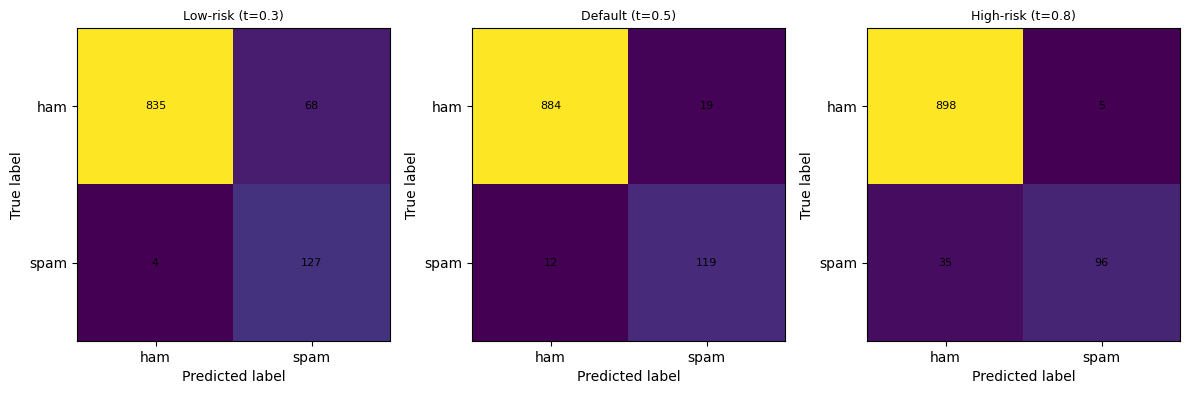

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_ax(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=["ham", "spam"])
    im = ax.imshow(cm)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["ham", "spam"])
    ax.set_yticklabels(["ham", "spam"])

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title, fontsize=9)

    # annotate cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

plot_confusion_matrix_ax(axes[0], y_test, y_pred_low,     "Low-risk (t=0.3)")
plot_confusion_matrix_ax(axes[1], y_test, y_pred_default, "Default (t=0.5)")
plot_confusion_matrix_ax(axes[2], y_test, y_pred_high,    "High-risk (t=0.8)")

plt.tight_layout()
plt.show()



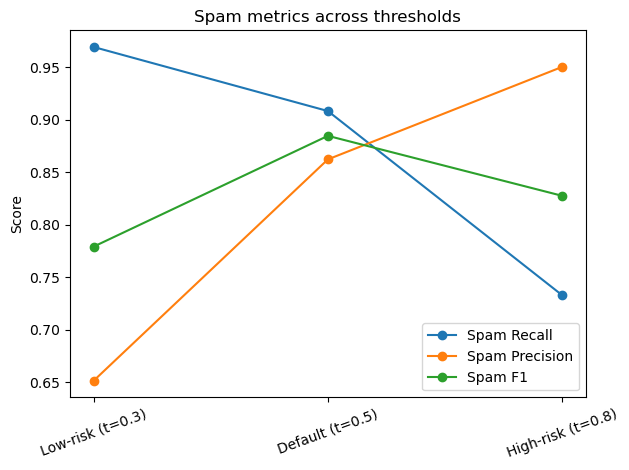

In [22]:
import matplotlib.pyplot as plt

modes = results_df["Mode"]

plt.figure()
plt.plot(modes, results_df["Spam Recall"], marker="o", label="Spam Recall")
plt.plot(modes, results_df["Spam Precision"], marker="o", label="Spam Precision")
plt.plot(modes, results_df["Spam F1"], marker="o", label="Spam F1")
plt.xticks(rotation=20)
plt.ylabel("Score")
plt.title("Spam metrics across thresholds")
plt.legend()
plt.tight_layout()
plt.show()


####  Key Takeaways 

- **There is no “perfect” threshold**: increasing spam detection will always increase false positives, and reducing false positives will always let more spam through.  
  The right choice depends on business priorities at a given moment.

- **The default threshold (t=0.5) provides the best overall balance**:  
  - High spam recall (catches most spam)  
  - High precision (few legitimate customers affected)  
  - Best F1-score across all modes  
  → Ideal as the **standard operating mode**.

- **Low-risk mode (t=0.3) is best when spam must be minimized at all costs**:  
  - Very high recall (almost all spam caught)  
  - But increases false positives → some legitimate messages get delayed or flagged.  
  → Use in periods of high spam volume or when protecting users is the top priority.

- **High-risk mode (t=0.8) is best when customer experience must be protected**:  
  - Very low false positives (almost no legitimate messages blocked)  
  - But lower recall (more spam slips through).  
  → Suitable when the focus is on reducing customer frustration or when message quality is generally high.

- **The availability of multiple thresholds gives flexibility**:  
  The team can dynamically switch modes depending on:
  - platform activity,
  - spam wave intensity,
  - marketing campaigns,
  - customer complaints,
  - or seasonal behavior patterns.

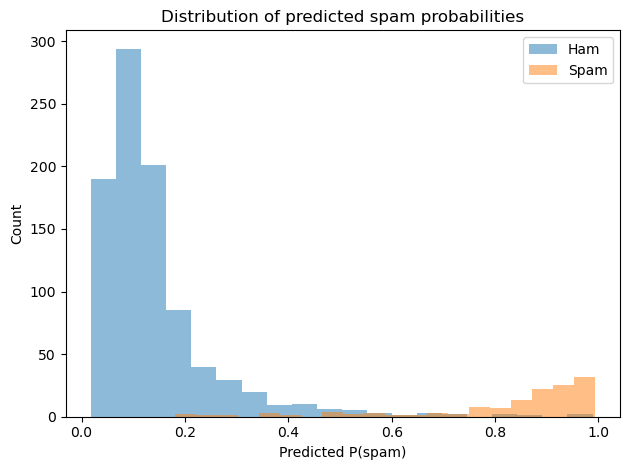

In [23]:
import matplotlib.pyplot as plt

# Assume y_test is "ham"/"spam"
spam_probas = y_proba_spam[y_test == "spam"]
ham_probas = y_proba_spam[y_test == "ham"]

plt.figure()
plt.hist(ham_probas, bins=20, alpha=0.5, label="Ham")
plt.hist(spam_probas, bins=20, alpha=0.5, label="Spam")
plt.xlabel("Predicted P(spam)")
plt.ylabel("Count")
plt.title("Distribution of predicted spam probabilities")
plt.legend()
plt.tight_layout()
plt.show()


###  Overall Conclusion — What the Probability Distribution Reveals

The distribution of predicted spam probabilities shows that the model separates *ham* and *spam* very clearly:  
- Legitimate messages (ham) cluster strongly near **P(spam) ~ 0.0–0.2**,  
- Spam messages cluster near **P(spam) ~ 0.7–1.0**,  
with only a small overlap between the two.

This means the classifier has a strong ability to distinguish between the two classes even before any threshold is applied. The small overlap zone is exactly where the adjustable thresholds (0.3, 0.5, 0.8) make practical operational sense.

---

###  Key Takeaways for the Service Team

- **The model is reliable:** Most ham is confidently predicted as non-spam, and most spam is confidently predicted as spam.  
  → This reduces the operational risk of heavy manual review.

- **Thresholds are meaningful because the overlap zone is small:**  
  Adjusting the threshold affects only a narrow band of “borderline” messages.  
  → The team can control spam filtering behaviour *without destabilizing* the system.

- **Low-risk mode (t=0.3)** targets the overlap zone aggressively, sending borderline messages to review.  
  → Best when spam volume peaks or during risky campaigns.

- **High-risk mode (t=0.8)** allows borderline messages to pass.  
  → Best when maintaining customer experience is more important than blocking rare spam.

- **Default mode (t=0.5)** sits at the natural separation point in the probability distribution.  
  → This threshold aligns with the model’s internal logic and is the most stable general-use option.

---

## Naive Bayes

In [25]:
from sklearn.naive_bayes import MultinomialNB
# Create Naive Bayes model
nb_model = MultinomialNB()

# Train
nb_model.fit(X_train_tfidf, y_train)

# Predictions
nb_pred = nb_model.predict(X_test_tfidf)

# Evaluation
print("=== Naive Bayes Baseline Model ===")
print("Accuracy:", accuracy_score(y_test, nb_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, nb_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, nb_pred))

=== Naive Bayes Baseline Model ===
Accuracy: 0.9729206963249516

Classification Report:

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       903
        spam       0.99      0.79      0.88       131

    accuracy                           0.97      1034
   macro avg       0.98      0.90      0.93      1034
weighted avg       0.97      0.97      0.97      1034

Confusion Matrix:
[[902   1]
 [ 27 104]]


In [26]:
print("Accuracy LR:", accuracy_score(y_test, y_pred))
print("Accuracy NB:", accuracy_score(y_test, nb_pred))

Accuracy LR: 0.9700193423597679
Accuracy NB: 0.9729206963249516


###  Comparison Between Naive Bayes and Logistic Regression

Although Naive Bayes and Logistic Regression achieve a very similar **overall accuracy**  
- **Naive Bayes (NB): 97.29%**  
- **Logistic Regression (LR): 97.00%**

the similarity in accuracy hides **important differences in error patterns** that strongly justify choosing Logistic Regression as the final model.

####  Strengths of Naive Bayes
- **Recall for ham = 1.00**, meaning NB almost never flags legitimate messages incorrectly.  
- Fast, simple, and surprisingly effective for short text messages.

####  Weaknesses of Naive Bayes (critical)
- **Recall for spam = 0.79**, which is significantly lower than LR (0.91).  
- This means NB *misses* far more spam messages — allowing them to pass as ham.
- The confusion matrix shows **27 false negatives (spam → ham)**, compared to **12 in LR**.

Given the business requirement to **control spam-risk levels**, false negatives are the most dangerous type of error. Letting spam go through harms customers and the platform, so LR is clearly safer.

####  Why Logistic Regression is the better final model
- Much higher **spam recall** (0.91 instead of 0.79).  
- Better ability to distinguish borderline spam vs ham.  
- Allows smoother threshold control (0.3 / 0.5 / 0.8) because the predicted probabilities are more calibrated.  
- Lower number of false negatives - the most important metric for safety.

####  Final takeaway
**Naive Bayes is a very strong baseline but unsafe as a final model due to high spam miss-rate.  
Logistic Regression is the correct choice because it catches more spam while still keeping false positives low and supports fine-grained threshold tuning.**


---

## Error Analysis

In [28]:
import pandas as pd

def get_error_examples(df, y_true, y_pred, error_type, n=10):
    """
    error_type: 'FP' or 'FN'
    n = number of examples to return
    """
    errors = pd.DataFrame({
        "text": df["final_text"].iloc[y_test.index],
        "true": y_true,
        "pred": y_pred
    })
    
    if error_type == "FP":
        return errors[(errors["true"] == "ham") & (errors["pred"] == "spam")].head(n)
    elif error_type == "FN":
        return errors[(errors["true"] == "spam") & (errors["pred"] == "ham")].head(n)
    else:
        raise ValueError("error_type must be 'FP' or 'FN'")


### Low-risk (t=0.3)

In [29]:
fp_low = get_error_examples(df, y_test, y_pred_low, "FP", n=10)
fn_low = get_error_examples(df, y_test, y_pred_low, "FN", n=10)

fp_low, fn_low


(                                                   text true  pred
 1590                               alright set text man  ham  spam
 81                                            k call ah  ham  spam
 3960  double eviction week spiral michael good riddance  ham  spam
 4530                                    liked new house  ham  spam
 1262                             daily text favour time  ham  spam
 2824                   mostly sport typelyk footblcrckt  ham  spam
 5100                 yes trust u buy new stuff asap try  ham  spam
 4080                                ü send content page  ham  spam
 3765          ow u deyi paid thousadi told u would call  ham  spam
 3522  plz note anyone calling mobile co amp asks u t...  ham  spam,
                                                    text  true pred
 1423  hi lucy hubby meetins day fri b alone hotel u ...  spam  ham
 3890  simpson movie released july name band died sta...  spam  ham
 5062  latest news police station toilet stolen

### Default (t=0.5)

In [30]:
fp_default = get_error_examples(df, y_test, y_pred_default, "FP", n=10)
fn_default = get_error_examples(df, y_test, y_pred_default, "FN", n=10)

fp_default, fn_default


(                                   text true  pred
 81                            k call ah  ham  spam
 1262             daily text favour time  ham  spam
 4080                ü send content page  ham  spam
 3152         much cost approx per month  ham  spam
 75             waiting machan call free  ham  spam
 487                    free nowcan call  ham  spam
 3481  sir waiting call free please call  ham  spam
 4806                        k k sm chat  ham  spam
 805                       road cant txt  ham  spam
 3586                 aight text address  ham  spam,
                                                    text  true pred
 2697  send logo ur lover name joined heart txt love ...  spam  ham
 5139  asked mobile chatlines inclu free min india cu...  spam  ham
 1423  hi lucy hubby meetins day fri b alone hotel u ...  spam  ham
 2303  babe u want dont u baby im nasty thing filthyg...  spam  ham
 3890  simpson movie released july name band died sta...  spam  ham
 3332  xmas new yea

### High-risk (t=0.8)

In [31]:
fp_high = get_error_examples(df, y_test, y_pred_high, "FP", n=10)
fn_high = get_error_examples(df, y_test, y_pred_high, "FN", n=10)

fp_high, fn_high


(                                   text true  pred
 75             waiting machan call free  ham  spam
 487                    free nowcan call  ham  spam
 3481  sir waiting call free please call  ham  spam
 4806                        k k sm chat  ham  spam
 3548                               call  ham  spam,
                                                    text  true pred
 5137  want explicit sex sec ring cost pmin gsex pobo...  spam  ham
 521   recieve tone within next hr term condition ple...  spam  ham
 621   today vodafone number ending selected receive ...  spam  ham
 2697  send logo ur lover name joined heart txt love ...  spam  ham
 1876  well done costa del sol holiday await collecti...  spam  ham
 484   congrats year special cinema pas call c suprma...  spam  ham
 2908  hi babe jordan r u im home abroad lonely text ...  spam  ham
 806   smsservices yourinclusive text credit pls goto...  spam  ham
 1611  hi ur lookin saucy daytime fun wiv busty marri...  spam  ham
 1405  

###  Why we extract FP/FN examples - Purpose of the Error Analysis

This step identifies and shows **real messages where the model fails**, so we can understand *why* errors happen and how they affect customers.  
The function extracts:

- **False Positives (FP)** → ham predicted as spam  
  *These are legitimate customer messages that get wrongly blocked.*

- **False Negatives (FN)** → spam predicted as ham  
  *These are harmful or unwanted messages that slip through the filter.*

By listing actual text examples for each threshold (0.3, 0.5, 0.8), we can:

- detect patterns in the errors  
- understand if mistakes come from informal language, emojis, short messages, marketing-like vocabulary, etc.  
- explain to the business team **where the model struggles**  
- justify why different thresholds have different trade-offs  
- propose follow-up strategies (manual review, retraining, filters for risky keywords, etc.)

**In short**:  
Error analysis transforms raw metrics into actionable understanding, helping both data scientists and the service team trust the model and improve decision-making.


---

##  Deployment Readiness — Saving the Model and Creating a Production Classifier

After completing the model training, evaluation, and threshold tuning, the final step is to prepare the system for real-world usage.  
In a production environment, the service team must be able to classify **new incoming messages** instantly, using the same preprocessing steps, the same TF-IDF transformation, and the same Logistic Regression model trained earlier.

To achieve this, we perform two final tasks:

### 1. Save the trained artifacts  
We store the **TF-IDF vectorizer** and the **Logistic Regression model** as serialized files (`.joblib`).  
This ensures the model can be loaded later *without retraining*, enabling deployment in applications, services, or a GUI.

### 2. Build a unified inference function  
We define a `classify_message()` function that:
- applies the **same preprocessing** used during training,  
- transforms the text using the saved TF-IDF vectorizer,  
- generates a probability `P(spam)`,  
- applies the selected **risk mode** (“low”, “default”, “high”),  
- returns the final label and probability in a clean structured format.

This function simulates how the model will operate inside the company's system, allowing the service team to:
- classify new messages in real time,  
- switch between strict or permissive spam filtering,  
- fully understand the reason behind each prediction.

This step completes the deployment phase of the project and demonstrates how the model can be directly integrated into the service workflow.


In [33]:
import os
import joblib  # pip install joblib se ainda não tiveres

# Choose a folder to store the artifacts
model_dir = r"C:\Users\nrebe\Downloads\Spam Filter\models"
os.makedirs(model_dir, exist_ok=True)

# File paths
tfidf_path = os.path.join(model_dir, "tfidf_vectorizer.joblib")
model_path = os.path.join(model_dir, "logreg_spam_classifier.joblib")

# Save fitted TF-IDF and Logistic Regression model
joblib.dump(tfidf, tfidf_path)
joblib.dump(log_reg, model_path)

print("Saved TF-IDF to:", tfidf_path)
print("Saved model  to:", model_path)


Saved TF-IDF to: C:\Users\nrebe\Downloads\Spam Filter\models\tfidf_vectorizer.joblib
Saved model  to: C:\Users\nrebe\Downloads\Spam Filter\models\logreg_spam_classifier.joblib


In [34]:
import re
import joblib
import numpy as np

# 1. Load saved TF-IDF and Logistic Regression model

model_dir = r"C:\Users\nrebe\Downloads\Spam Filter\models"

tfidf = joblib.load(fr"{model_dir}\tfidf_vectorizer.joblib")
log_reg = joblib.load(fr"{model_dir}\logreg_spam_classifier.joblib")

# 2. Preprocessing function (same as training)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\S+@\S+\.\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 3. Classification with thresholds

def classify_message(message, mode="default"):
    
    thresholds = {
        "low": 0.30,
        "default": 0.50,
        "high": 0.80
    }
    
    if mode not in thresholds:
        raise ValueError("Mode must be 'low', 'default', or 'high'.")

    threshold = thresholds[mode]
    
    # Preprocess
    clean = preprocess_text(message)
    
    # Vectorize
    vect = tfidf.transform([clean])
    
    # Predict probability
    proba_spam = log_reg.predict_proba(vect)[0][1]
    
    # Apply threshold
    label = "spam" if proba_spam >= threshold else "ham"
    
    return {
        "clean_text": clean,
        "probability_spam": round(proba_spam, 4),
        "label": label,
        "threshold_used": threshold,
        "mode": mode
    }



---

### Usage Exemple 

In [36]:
classify_message("WINNER! You have won a free iPhone!", mode="low")


{'clean_text': 'winner you have won a free iphone',
 'probability_spam': 0.8117,
 'label': 'spam',
 'threshold_used': 0.3,
 'mode': 'low'}

In [37]:
classify_message("Hey bro, are we still meeting tonight?", mode="high")

{'clean_text': 'hey bro are we still meeting tonight',
 'probability_spam': 0.0364,
 'label': 'ham',
 'threshold_used': 0.8,
 'mode': 'high'}

In [38]:
classify_message("URGENT! Update your bank account now!", mode="default")

{'clean_text': 'urgent update your bank account now',
 'probability_spam': 0.5999,
 'label': 'spam',
 'threshold_used': 0.5,
 'mode': 'default'}